# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                          
Sample_156  O94772;O94772-2                            19.565
Sample_006  P05452                                     18.794
Sample_171  P13473;P13473-2;P13473-3                   18.665
Sample_138  A0A0A0MRJ6;F6S8N6;H7BY58;P22061;P22061-2   17.961
Sample_092  Q9NZC2;Q9NZC2-2;Q9NZC2-3                   16.638
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                            
Sample_023  P35754                                       15.067
Sample_035  Q15084;Q15084-2;Q15084-3;Q15084-4;Q15084-5   15.355
Sample_126  Q16799                                       12.956
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.651
            A0A075B6Q5                 12.261
            A0A075B6R2                 12.338
            A0A075B6S5                 12.700
            A0A087WSY4                 12.024
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.186
            Q9UI40;Q9UI40-2            11.748
            Q9UIW2                     12.477
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.276
            Q9UP79                     12.536
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.273,15.050,16.842,19.863,15.842,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.882,19.067,...,15.528,15.576,14.018,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.844,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.221,17.705,17.039,15.805,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.454,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.431,15.345,17.084,18.708,14.249,19.433,11.239,10.910
Sample_207,15.739,16.877,15.469,16.898,14.373,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.651,...,16.012,15.178,11.789,15.050,16.842,19.863,14.649,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.032,19.067,16.188,...,15.528,15.576,13.871,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.222,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.946,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.837,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.200,15.345,17.084,18.708,14.249,19.433,11.965,13.075
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 338.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.93it/s]

100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.66it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.31it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.91it/s]

100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.03it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.42it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.94it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.98it/s]

100%|██████████| 6/6 [00:01<00:00,  2.94it/s]

100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.77it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.85it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.71it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.56it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.42it/s]

100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.43it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.71it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.22it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.11it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.06it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.94it/s]

100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.29it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.27it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.47it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.30it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.08it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.02it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.30it/s]

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.66it/s]

 30%|███       | 3/10 [00:01<00:02,  2.82it/s]

 40%|████      | 4/10 [00:01<00:02,  2.49it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.54it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.51it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.55it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.66it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.09it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.88it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.43it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.64it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.63it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.77it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.66it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.70it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.72it/s]

100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

100%|██████████| 11/11 [00:04<00:00,  2.61it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.76it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.03it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.53it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.32it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.30it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.19it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.03it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.02it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.12it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.31it/s]

100%|██████████| 12/12 [00:05<00:00,  2.36it/s]

100%|██████████| 12/12 [00:05<00:00,  2.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.20it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.97it/s]

 31%|███       | 4/13 [00:01<00:03,  2.68it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.53it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.20it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.15it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.06it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.26it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.32it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.39it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.47it/s]

100%|██████████| 13/13 [00:05<00:00,  2.59it/s]

100%|██████████| 13/13 [00:05<00:00,  2.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.16it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.07it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.00it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.83it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.76it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.57it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.29it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.22it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.11it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.97it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.11it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.33it/s]

100%|██████████| 14/14 [00:05<00:00,  2.46it/s]

100%|██████████| 14/14 [00:05<00:00,  2.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.10it/s]

 20%|██        | 3/15 [00:00<00:03,  3.87it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.33it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.11it/s]

 40%|████      | 6/15 [00:01<00:03,  2.87it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.76it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.88it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.72it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.51it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.33it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.23it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.18it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.46it/s]

100%|██████████| 15/15 [00:05<00:00,  2.59it/s]

100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.004      0.066 0.026          0.736 0.369       0.109   
2             0.005 0.004      0.078 0.031          0.758 0.090       0.709   
3             0.004 0.002      0.058 0.018          0.755 0.088       0.712   
4             0.005 0.004      0.071 0.028          0.789 0.097       0.778   
5             0.005 0.004      0.063 0.023          0.779 0.088       0.778   
6             0.004 0.001      0.051 0.015          0.782 0.089       0.793   
7             0.004 0.003      0.058 0.021          0.839 0.082       0.819   
8             0.005 0.004      0.061 0.022          0.842 0.076       0.821   
9             0.004 0.000      0.048 0.007          0.833 0.074       0.819   
10            0.005 0.004      0.058 0.019          0.828 0.072       0.812   
11            0.006 0.005      0.063 0.026          0.828 0.075       0.808   
12            0.005 0.003      0.054 0.018          0.823 0.075       0.809   
13            0.004 0.003      0.050 0.011          0.823 0.075       0.807   
14            0.005 0.003      0.068 0.026          0.819 0.087       0.811   
15            0.006 0.005      0.074 0.029          0.817 0.089       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.182 0.129                  0.547 0.040        0.855   
2          0.092   0.726 0.060                  0.768 0.048        0.856   
3          0.087   0.728 0.066                  0.769 0.053        0.857   
4          0.095   0.779 0.072                  0.810 0.062        0.894   
5          0.091   0.774 0.065                  0.806 0.056        0.898   
6          0.096   0.783 0.071                  0.814 0.062        0.897   
7          0.101   0.824 0.071                  0.850 0.060        0.912   
8          0.102   0.827 0.069                  0.853 0.058        0.911   
9          0.093   0.822 0.065                  0.848 0.055        0.912   
10         0.099   0.817 0.069                  0.844 0.057        0.910   
11         0.098   0.815 0.070                  0.842 0.058        0.910   
12         0.096   0.813 0.069                  0.840 0.057        0.908   
13         0.094   0.811 0.066                  0.839 0.055        0.907   
14         0.095   0.811 0.070                  0.838 0.060        0.909   
15         0.097   0.809 0.071                  0.836 0.060        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.825 0.089        210.000 0.000  
2          0.060                  0.833 0.067        210.000 0.000  
3          0.059                  0.839 0.066        210.000 0.000  
4          0.053                  0.878 0.060        210.000 0.000  
5          0.049                  0.883 0.052        210.000 0.000  
6          0.050                  0.882 0.054        210.000 0.000  
7          0.053                  0.898 0.056        210.000 0.000  
8          0.053                  0.898 0.057        210.000 0.000  
9          0.053                  0.900 0.056        210.000 0.000  
10         0.054                  0.898 0.056        210.000 0.000  
11         0.055                  0.897 0.058        210.000 0.000  
12         0.055                  0.895 0.059        210.000 0.000  
13         0.056                  0.892 0.060        210.000 0.000  
14         0.054                  0.898 0.056        210.000 0.000  
15         0.053                  0.895 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 495.31it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.35it/s]

100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.33it/s]

100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.95it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.19it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.73it/s]

100%|██████████| 5/5 [00:01<00:00,  2.31it/s]

100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.56it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.98it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.87it/s]

100%|██████████| 6/6 [00:01<00:00,  2.93it/s]

100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.70it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.50it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.13it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.47it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.43it/s]

100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.56it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.67it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.23it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.36it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.40it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.34it/s]

100%|██████████| 8/8 [00:03<00:00,  2.32it/s]

100%|██████████| 8/8 [00:03<00:00,  2.41it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.32it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.69it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.48it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.28it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.18it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.85it/s]

100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.46it/s]

 30%|███       | 3/10 [00:00<00:02,  3.26it/s]

 40%|████      | 4/10 [00:01<00:02,  2.99it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.94it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.64it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.68it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.76it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.79it/s]

100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.21it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.53it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.17it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.79it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.11it/s]

100%|██████████| 11/11 [00:05<00:00,  2.26it/s]

100%|██████████| 11/11 [00:05<00:00,  2.08it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.38it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.66it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.37it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.14it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.05it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.85it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.48it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.16it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.89it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.76it/s]

100%|██████████| 12/12 [00:05<00:00,  1.69it/s]

100%|██████████| 12/12 [00:05<00:00,  2.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.30it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.87it/s]

 31%|███       | 4/13 [00:01<00:03,  2.74it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.76it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.27it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.10it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.12it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.25it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.34it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.36it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.18it/s]

100%|██████████| 13/13 [00:05<00:00,  2.22it/s]

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.34it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.98it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.81it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.54it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.30it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.17it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.25it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.35it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.23it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.30it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.37it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.53it/s]

100%|██████████| 14/14 [00:05<00:00,  2.66it/s]

100%|██████████| 14/14 [00:05<00:00,  2.55it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.80it/s]

 20%|██        | 3/15 [00:00<00:03,  3.45it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.16it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.09it/s]

 40%|████      | 6/15 [00:01<00:02,  3.03it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.90it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.91it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.71it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.57it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.62it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.64it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.40it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.13it/s]

100%|██████████| 15/15 [00:05<00:00,  1.99it/s]

100%|██████████| 15/15 [00:05<00:00,  2.56it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.054 0.017          0.010 0.071       0.001   
2             0.004 0.002      0.064 0.029          0.769 0.120       0.624   
3             0.004 0.004      0.056 0.020          0.758 0.089       0.670   
4             0.004 0.003      0.055 0.019          0.757 0.091       0.669   
5             0.005 0.003      0.061 0.019          0.741 0.098       0.658   
6             0.005 0.003      0.065 0.026          0.735 0.099       0.668   
7             0.004 0.003      0.051 0.020          0.747 0.104       0.697   
8             0.005 0.004      0.056 0.019          0.748 0.102       0.692   
9             0.004 0.002      0.050 0.014          0.768 0.098       0.748   
10            0.004 0.000      0.052 0.014          0.782 0.088       0.794   
11            0.006 0.004      0.067 0.024          0.781 0.088       0.790   
12            0.005 0.004      0.061 0.022          0.786 0.094       0.802   
13            0.005 0.004      0.067 0.032          0.787 0.095       0.802   
14            0.004 0.003      0.047 0.024          0.796 0.091       0.781   
15            0.005 0.004      0.056 0.016          0.794 0.091       0.778   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.859   
2          0.124   0.679 0.092                  0.738 0.070        0.789   
3          0.117   0.705 0.084                  0.756 0.063        0.853   
4          0.115   0.704 0.084                  0.755 0.062        0.851   
5          0.131   0.689 0.090                  0.743 0.069        0.869   
6          0.135   0.693 0.096                  0.744 0.073        0.868   
7          0.134   0.715 0.100                  0.761 0.080        0.876   
8          0.131   0.713 0.097                  0.760 0.077        0.873   
9          0.124   0.753 0.093                  0.790 0.077        0.887   
10         0.108   0.784 0.079                  0.815 0.067        0.913   
11         0.115   0.781 0.079                  0.813 0.067        0.913   
12         0.117   0.789 0.085                  0.819 0.073        0.915   
13         0.119   0.789 0.087                  0.820 0.074        0.914   
14         0.114   0.784 0.082                  0.816 0.069        0.918   
15         0.111   0.781 0.082                  0.814 0.068        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.827 0.086        210.000 0.000  
2          0.074                  0.733 0.093        210.000 0.000  
3          0.058                  0.820 0.071        210.000 0.000  
4          0.058                  0.818 0.069        210.000 0.000  
5          0.054                  0.838 0.066        210.000 0.000  
6          0.054                  0.839 0.063        210.000 0.000  
7          0.058                  0.847 0.069        210.000 0.000  
8          0.059                  0.843 0.069        210.000 0.000  
9          0.057                  0.867 0.064        210.000 0.000  
10         0.047                  0.895 0.054        210.000 0.000  
11         0.047                  0.893 0.053        210.000 0.000  
12         0.047                  0.896 0.054        210.000 0.000  
13         0.047                  0.895 0.054        210.000 0.000  
14         0.046                  0.899 0.054        210.000 0.000  
15         0.046                  0.896 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 980.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 25.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.78it/s]

100%|██████████| 3/3 [00:00<00:00, 16.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 14.36it/s]

100%|██████████| 4/4 [00:00<00:00, 12.95it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.45it/s]

100%|██████████| 5/5 [00:00<00:00, 15.38it/s]

100%|██████████| 5/5 [00:00<00:00, 15.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.56it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.77it/s]

100%|██████████| 6/6 [00:00<00:00, 11.90it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.26it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.55it/s]

100%|██████████| 7/7 [00:00<00:00, 14.61it/s]

100%|██████████| 7/7 [00:00<00:00, 15.07it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 18.82it/s]

 50%|█████     | 4/8 [00:00<00:00, 17.68it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.43it/s]

100%|██████████| 8/8 [00:00<00:00, 14.56it/s]

100%|██████████| 8/8 [00:00<00:00, 15.37it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.21it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 19.40it/s]

100%|██████████| 9/9 [00:00<00:00, 20.20it/s]

100%|██████████| 9/9 [00:00<00:00, 20.20it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.77it/s]

 40%|████      | 4/10 [00:00<00:00, 12.26it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.06it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.08it/s]

100%|██████████| 10/10 [00:00<00:00, 11.37it/s]

100%|██████████| 10/10 [00:00<00:00, 11.30it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.40it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.26it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.78it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.03it/s]

100%|██████████| 11/11 [00:00<00:00, 13.38it/s]

100%|██████████| 11/11 [00:00<00:00, 13.62it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.09it/s]

 33%|███▎      | 4/12 [00:00<00:00, 13.56it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.11it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.00it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.74it/s]

100%|██████████| 12/12 [00:01<00:00, 10.65it/s]

100%|██████████| 12/12 [00:01<00:00, 10.88it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.75it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.98it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.40it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.78it/s]

100%|██████████| 13/13 [00:00<00:00, 16.71it/s]

100%|██████████| 13/13 [00:00<00:00, 16.21it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 18.90it/s]

 29%|██▊       | 4/14 [00:00<00:00, 12.48it/s]

 43%|████▎     | 6/14 [00:00<00:00, 10.28it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.93it/s]

 71%|███████▏  | 10/14 [00:00<00:00,  9.92it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.30it/s]

100%|██████████| 14/14 [00:01<00:00, 10.96it/s]

100%|██████████| 14/14 [00:01<00:00, 10.82it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 13.76it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.40it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.28it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.79it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 15.33it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 16.22it/s]

100%|██████████| 15/15 [00:01<00:00, 15.67it/s]

100%|██████████| 15/15 [00:01<00:00, 14.96it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.062 0.022          0.000 0.000       0.000   
2             0.004 0.003      0.068 0.028          0.667 0.121       0.491   
3             0.004 0.003      0.054 0.026          0.661 0.123       0.492   
4             0.006 0.006      0.069 0.026          0.686 0.125       0.492   
5             0.005 0.004      0.064 0.023          0.632 0.103       0.514   
6             0.005 0.004      0.054 0.016          0.644 0.100       0.553   
7             0.004 0.002      0.051 0.015          0.629 0.092       0.552   
8             0.004 0.003      0.044 0.014          0.672 0.099       0.576   
9             0.004 0.002      0.044 0.018          0.662 0.097       0.565   
10            0.004 0.000      0.051 0.015          0.656 0.096       0.562   
11            0.005 0.004      0.050 0.015          0.651 0.095       0.557   
12            0.004 0.001      0.048 0.015          0.652 0.099       0.552   
13            0.003 0.001      0.041 0.012          0.650 0.097       0.544   
14            0.005 0.003      0.054 0.015          0.647 0.097       0.541   
15            0.004 0.002      0.046 0.010          0.653 0.092       0.613   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.731   
2          0.108   0.561 0.102                  0.656 0.069        0.705   
3          0.106   0.559 0.101                  0.653 0.070        0.698   
4          0.110   0.567 0.103                  0.662 0.071        0.693   
5          0.104   0.561 0.085                  0.646 0.062        0.739   
6          0.114   0.589 0.093                  0.664 0.068        0.774   
7          0.120   0.582 0.095                  0.657 0.067        0.771   
8          0.120   0.614 0.094                  0.684 0.070        0.775   
9          0.115   0.603 0.089                  0.675 0.065        0.770   
10         0.126   0.598 0.096                  0.672 0.070        0.769   
11         0.124   0.593 0.094                  0.668 0.067        0.767   
12         0.124   0.591 0.094                  0.667 0.069        0.770   
13         0.115   0.585 0.088                  0.663 0.065        0.768   
14         0.114   0.582 0.088                  0.661 0.066        0.764   
15         0.112   0.626 0.086                  0.686 0.068        0.781   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.685 0.083        210.000 0.000  
2          0.075                  0.681 0.082        210.000 0.000  
3          0.076                  0.674 0.085        210.000 0.000  
4          0.073                  0.673 0.083        210.000 0.000  
5          0.062                  0.704 0.070        210.000 0.000  
6          0.062                  0.725 0.075        210.000 0.000  
7          0.062                  0.723 0.075        210.000 0.000  
8          0.062                  0.736 0.070        210.000 0.000  
9          0.062                  0.730 0.069        210.000 0.000  
10         0.063                  0.727 0.072        210.000 0.000  
11         0.063                  0.722 0.073        210.000 0.000  
12         0.062                  0.725 0.072        210.000 0.000  
13         0.064                  0.723 0.076        210.000 0.000  
14         0.064                  0.718 0.077        210.000 0.000  
15         0.066                  0.733 0.082 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,11,4
score_time,2,13,4
test_precision,8,14,4
test_recall,8,13,15
test_f1,8,13,15
test_balanced_accuracy,8,13,15
test_roc_auc,9,14,15
test_average_precision,9,14,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.10it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.38it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.73it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.41it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.26it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.68it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.35it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.17it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.34it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.41it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.66it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.87it/s]

100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.86it/s]

 40%|████      | 6/15 [00:00<00:00, 17.29it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.64it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 16.38it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.98it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 16.18it/s]

100%|██████████| 15/15 [00:00<00:00, 16.59it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.39it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.00it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.59it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.87it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.86it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.73it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.62it/s]

100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


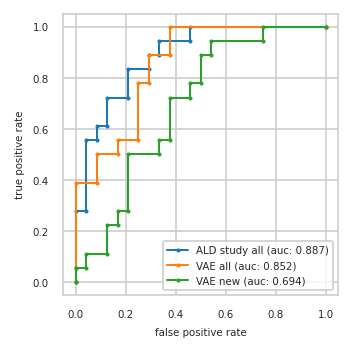

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.278   0.000 0.389   0.042 0.056
3          0.042 0.278   0.083 0.389   0.042 0.111
4          0.042 0.556   0.083 0.500   0.125 0.111
5          0.083 0.556   0.167 0.500   0.125 0.222
6          0.083 0.611   0.167 0.556   0.167 0.222
7          0.125 0.611   0.250 0.556   0.167 0.278
8          0.125 0.722   0.250 0.778   0.208 0.278
9          0.208 0.722   0.292 0.778   0.208 0.500
10         0.208 0.833   0.292 0.889   0.333 0.500
11         0.292 0.833   0.375 0.889   0.333 0.556
12         0.292 0.889   0.375 1.000   0.375 0.556
13         0.333 0.889   1.000 1.000   0.375 0.722
14         0.333 0.944     NaN   NaN   0.458 0.722
15         0.458 0.944     NaN   NaN   0.458 0.778
16         0.458 1.000     NaN   NaN   0.500 0.778
17         1.000 1.000     NaN   NaN   0.500 0.889
18           NaN   NaN     NaN   NaN   0.542 0.889
19           NaN   NaN     NaN   NaN   0.542 0.944
20           NaN   NaN     NaN   NaN   0.750 0.944
21           NaN   NaN     NaN   NaN   0.750 1.000
22           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,P22676,P51688
2,Q99969,Q14894,Q96MU8;Q96MU8-2;Q96MU8-3
3,P61981,P63104,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
4,P04075,Q9Y2T3;Q9Y2T3-3,Q9NUQ9
5,P14174,A0A0A0MRJ7;P12259,P31321
6,Q9Y2T3;Q9Y2T3-3,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P00338;P00338-3,P04075,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6
8,C9JF17;P05090,P14174,Q96GD0


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


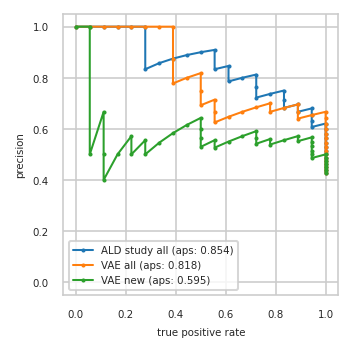

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.621 1.000     0.621 1.000     0.552 0.889
14         0.607 0.944     0.643 1.000     0.571 0.889
15         0.630 0.944     0.667 1.000     0.556 0.833
16         0.654 0.944     0.654 0.944     0.538 0.778
17         0.680 0.944     0.640 0.889     0.560 0.778
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.696 0.889     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.737 0.778     0.684 0.722     0.526 0.556
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.765 0.722     0.647 0.611     0.529 0.500
26         0.812 0.722     0.625 0.556     0.562 0.500
27         0.800 0.667     0.667 0.556     0.600 0.500
28         0.786 0.611     0.714 0.556     0.643 0.500
29         0.846 0.611     0.692 0.500     0.615 0.444
30         0.833 0.556     0.750 0.500     0.583 0.389
31         0.909 0.556     0.818 0.500     0.545 0.333
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.778 0.389     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         0.857 0.333     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


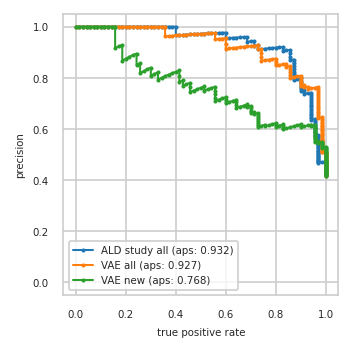

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


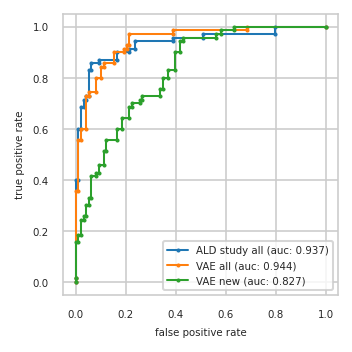

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}